# Distributed

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukeconibear/intro_ml/blob/main/docs/05_distributed.ipynb)

In [ ]:
# if you're using colab, then install the required modules
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    pass

```{note}
If you’re in COLAB or have a local CUDA GPU, you can follow along with the more computationally intensive training in this lesson.

For those in COLAB, ensure the session is using a GPU by going to: Runtime > Change runtime type > Hardware accelerator = GPU.
```

Distributing training over multiple devices generally uses either:

- [Data parallelism](https://developers.google.com/machine-learning/glossary/#data-parallelism)
    - Single model copied to multiple devices.
    - Split data over multiple devices.
    - Useful for big data.
- [Model parallelism](https://developers.google.com/machine-learning/glossary/#model-parallelism)
    - Split model over multiple devices.
    - Single data copied to multiple devices.
    - Useful for big models (for some architectures).
    
This lesson focuses on data parallelism.

## [Ray Train](https://docs.ray.io/en/latest/train/train.html)

Ray Train simplifies distributed deep learning for TensorFlow and PyTorch.

It handles the set up for you (e.g., [`TF_CONFIG`](https://www.tensorflow.org/guide/distributed_training#setting_up_the_tf_config_environment_variable) in TensorFlow).

There are a range of examples [here](https://docs.ray.io/en/latest/train/examples.html).

```{warning}
Note, Ray doesn't currently work on POWER9 machines e.g., Bede. See, [GitHub issue](https://github.com/ray-project/ray/issues/7476).
```

### [TensorFlow (Keras)](https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras)

Here is an [MNIST example](https://docs.ray.io/en/latest/train/examples/tensorflow_mnist_example.html):

In [ ]:
import argparse
import json
import os

import numpy as np
import ray
import tensorflow as tf
from ray.train import Trainer
from tensorflow.keras.callbacks import Callback

#### [Define callback for reporting](https://docs.ray.io/en/latest/train/user_guide.html#logging-monitoring-and-callbacks)

In [ ]:
class TrainReportCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        ray.train.report(**logs)

#### Set up the dataset and model

The dataset will be split (sharded) across the workers.

```{tip}
The default [auto-sharding](https://www.tensorflow.org/tutorials/distribute/input#sharding) by `FILE` can cause warning messages if the data is in one file. Instead, auto-shard by data using: `tf.data.experimental.AutoShardPolicy.DATA`
```

In [ ]:
def mnist_dataset(batch_size):
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # The `x` arrays are in uint8 and have values in the [0, 255] range.
    # You need to convert them to float32 with values in the [0, 1] range.
    x_train = x_train / np.float32(255)
    y_train = y_train.astype(np.int64)
    ds_train = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .shuffle(60000)
        .repeat()
        .batch(batch_size)
    )

    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = (
        tf.data.experimental.AutoShardPolicy.DATA
    )
    ds_train = ds_train.with_options(options)

    return ds_train

In [ ]:
def build_and_compile_cnn_model(config):
    learning_rate = config.get("lr", 0.001)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=["accuracy"],
    )
    return model

#### Set up the training function for a _single_ worker

You can [configure training](https://docs.ray.io/en/latest/train/user_guide.html#configuring-training) using the `config` parameter.

In [ ]:
def train_func(config):
    batch_size = 64
    single_worker_dataset = mnist_dataset(batch_size)
    single_worker_model = build_and_compile_cnn_model(config)
    single_worker_model.fit(
        single_worker_dataset,
        epochs=config["epochs"],
        steps_per_epoch=70,
        verbose=False,
    )

In [ ]:
config = {"epochs": 3}

In [ ]:
train_func(config)

#### [Update training function](https://docs.ray.io/en/latest/train/user_guide.html#update-training-function)

1. Set the _global_ batch size
    - Each worker will process the same size batch as in the single-worker code.
2. Choose your TensorFlow distributed training strategy.
    - In this example we use the [MultiWorkerMirroredStrategy](https://www.tensorflow.org/guide/distributed_training#multiworkermirroredstrategy) for synchronous training of multiple workers across many machines.
        - For multiple workers on _one_ machine, use [MirroredStrategy](https://www.tensorflow.org/api_docs/python/tf/distribute/MirroredStrategy).
        - In general, the mirrored strategy mirrors the parameters across the workers, ensuring replicas are identical.
    - Within the strategy scope context manager, you build and compile the model.

In [ ]:
def train_func(config):
    per_worker_batch_size = config.get("batch_size", 64)
    epochs = config.get("epochs", 3)
    steps_per_epoch = config.get("steps_per_epoch", 70)

    tf_config = json.loads(os.environ["TF_CONFIG"])
    num_workers = len(tf_config["cluster"]["worker"])

    strategy = tf.distribute.MultiWorkerMirroredStrategy()

    global_batch_size = per_worker_batch_size * num_workers
    multi_worker_dataset = mnist_dataset(global_batch_size)

    with strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = build_and_compile_cnn_model(config)

    history = multi_worker_model.fit(
        multi_worker_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[TrainReportCallback()],
        verbose=False,
    )
    results = history.history
    return results

#### [Create Ray Train Trainer](https://docs.ray.io/en/latest/train/user_guide.html#create-ray-train-trainer)

The `Trainer` manages state and training.

In [ ]:
def train_tensorflow_mnist(num_workers=1, use_gpu=False, epochs=4):
    trainer = Trainer(backend="tensorflow", num_workers=num_workers, use_gpu=use_gpu)
    trainer.start()
    results = trainer.run(
        train_func=train_func, config={"lr": 1e-3, "batch_size": 64, "epochs": epochs}
    )
    trainer.shutdown()
    print(f"Results: {results[0]}")

#### [Run the training](https://docs.ray.io/en/latest/train/user_guide.html#run-training-function)

Initialise and shutdown the Ray client:

In [ ]:
# ray.init()

In [ ]:
# cpu
# train_tensorflow_mnist()

# gpu
# train_tensorflow_mnist(use_gpu=True)

In [ ]:
# ray.shutdown()

This Python script is in full [here](https://github.com/lukeconibear/intro_ml/blob/main/docs/distributed/tensorflow_ray_train_mnist_example.py).

The job submission script is (also [here](https://github.com/lukeconibear/intro_ml/blob/main/docs/distributed/distributed_ml_on_arc4_cpu.bash)):

```bash
#!/bin/bash
#$ -cwd
#$ -l h_rt=00:30:00
#$ -pe smp 12
#$ -l h_vmem=6G

conda activate intro_ml
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib  # (sometimes needed)

python tensorflow_ray_train_mnist_example.py --num-workers 12 --epochs 100
```

In this simple example using 12 CPUs, the job efficiency (using `qacct -j <JOBID>`):

```
Efficiency = 100 * cpu / (ru_wallclock * slots)
Efficiency = 100 * 10214 / (928 * 12)
Efficiency = 92 %
```

92% is good.

To run on the GPU ([submission script](https://github.com/lukeconibear/intro_ml/blob/main/docs/distributed/distributed_ml_on_arc4_gpu.bash)):
- Replace `#$ -pe smp 4` with `#$ -l coproc_v100=1`.
- Add `--use-gpu=True`.

### [PyTorch](https://pytorch.org/tutorials/beginner/dist_overview.html)

Can also distribute with [Ray Train](https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html).

To share data on a single filesystem, download the dataset once:

```python
Trainer(prepare_data_per_node=False)
```

The default behaviour is to download the data _once per node_. 

#### [DDP Strategy](https://pytorch-lightning.readthedocs.io/en/stable/advanced/model_parallel.html#ddp-optimizations)


```python
# train on 8 GPUs, using the DDP strategy
trainer = Trainer(accelerator="gpu", devices=8, strategy="ddp")
```
...


```python
# train on multiple GPUs across nodes (uses 8 GPUs in total)
trainer = Trainer(accelerator="gpu", devices=2, num_nodes=4)
```

`num_workers`

https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#num-workers

In [ ]:
import argparse
from typing import Dict

import ray
import torch
from ray.train.callbacks import JsonLoggerCallback
from ray.train.trainer import Trainer
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#### Set up the dataset and model

In [ ]:
# training_data = datasets.FashionMNIST(
#     root="~/data",
#     train=True,
#     download=True,
#     transform=ToTensor(),
# )

# test_data = datasets.FashionMNIST(
#     root="~/data",
#     train=False,
#     download=True,
#     transform=ToTensor(),
# )

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

#### Define training and validation per epoch

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) // ray.train.world_size()
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def validate_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) // ray.train.world_size()
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n "
        f"Accuracy: {(100 * correct):>0.1f}%, "
        f"Avg loss: {test_loss:>8f} \n"
    )
    return test_loss

#### [Setup distributed training function](https://docs.ray.io/en/latest/train/user_guide.html#update-training-function)

Use `ray.train.torch.prepare_model` to automatically move your model to the right device.

Use `ray.train.torch.prepare_data_loader` utility functions to setup your data for distributed training.

In [ ]:
def train_func(config: Dict):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]

    worker_batch_size = batch_size // ray.train.world_size()

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=worker_batch_size)
    test_dataloader = DataLoader(test_data, batch_size=worker_batch_size)

    train_dataloader = ray.train.torch.prepare_data_loader(train_dataloader)
    test_dataloader = ray.train.torch.prepare_data_loader(test_dataloader)

    # Create model.
    model = NeuralNetwork()
    model = ray.train.torch.prepare_model(model)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    loss_results = []

    for _ in range(epochs):
        train_epoch(train_dataloader, model, loss_fn, optimizer)
        loss = validate_epoch(test_dataloader, model, loss_fn)
        ray.train.report(loss=loss)
        loss_results.append(loss)

    return loss_results

#### [Create Ray Train Trainer](https://docs.ray.io/en/latest/train/user_guide.html#create-ray-train-trainer)

In [ ]:
def train_fashion_mnist(num_workers=1, use_gpu=False):
    trainer = Trainer(backend="torch", num_workers=num_workers, use_gpu=use_gpu)
    trainer.start()
    result = trainer.run(
        train_func=train_func,
        config={"lr": 1e-3, "batch_size": 64, "epochs": 4},
        callbacks=[JsonLoggerCallback()],
    )
    trainer.shutdown()
    print(f"Loss results: {result}")

#### [Run the training](https://docs.ray.io/en/latest/train/user_guide.html#run-training-function)

In [ ]:
# ray.init()

In [ ]:
# cpu
# train_fashion_mnist()

# gpu
# train_fashion_mnist(use_gpu=True)

In [ ]:
# ray.shutdown()

This Python script is in full [here](https://github.com/lukeconibear/intro_ml/blob/main/docs/distributed/pytorch_ray_train_fashion_mnist_example.py).

The job submission script is the same as before ([here](https://github.com/lukeconibear/intro_ml/blob/main/docs/distributed/distributed_ml_on_arc4_cpu.bash)), except you use the line:

```bash
python tensorflow_ray_train_mnist_example.py --num-workers 12 --epochs 100
```

In this simple example using 12 CPUs, the job efficiency (using `qacct -j <JOBID>`):

```
Efficiency = 100 * cpu / (ru_wallclock * slots)
Efficiency = 100 * X / (X * 12)
Efficiency = X %
```

...

To run on the GPU ([submission script](https://github.com/lukeconibear/intro_ml/blob/main/docs/distributed/distributed_ml_on_arc4_gpu.bash)):
- Replace `#$ -pe smp 4` with `#$ -l coproc_v100=1`.
- Add `--use-gpu=True`.

## [PyTorch (Lightning)](https://pytorch-lightning.readthedocs.io/en/stable/clouds/cluster.html)


[SLURM](https://pytorch-lightning.readthedocs.io/en/stable/clouds/cluster.html#slurm-managed-cluster)


```python
# train.py
def main(hparams):
    model = LightningTemplateModel(hparams)

    trainer = Trainer(accelerator="gpu", devices=8, num_nodes=4, strategy="ddp")

    trainer.fit(model)


if __name__ == "__main__":
    root_dir = os.path.dirname(os.path.realpath(__file__))
    parent_parser = ArgumentParser(add_help=False)
    hyperparams = parser.parse_args()

    # TRAIN
    main(hyperparams)
```

```bash
# (submit.sh)
#!/bin/bash -l

# SLURM SUBMIT SCRIPT
#SBATCH --nodes=4
#SBATCH --gres=gpu:8
#SBATCH --ntasks-per-node=8
#SBATCH --mem=0
#SBATCH --time=0-02:00:00

conda activate swd8_intro_ml

srun python3 train.py
```

```
sbatch submit.sh
```

```{tip}
Some errors can show up as an [NCCL](https://developer.nvidia.com/nccl) issue.  

Set the `NCCL_DEBUG=INFO` environment variable to see the ACTUAL error:  

`NCCL_DEBUG=INFO python train.py`  
```

## Jupyter Notebook to HPC

Once you've finished testing out different ideas locally in a Jupyter Notebook, you can then convert this to an exercutable script to run on a HPC.

This is because the HPCs (currently accessible at Leeds, at least) are suitable for non-interactive batch jobs.

The steps are to:

- [Clean non-essential code](clean_nonessential_code)
- [Refactor Jupyter Notebook code into functions](refactor_into_functions)
- [Create a Python script](create_python_script)
- [Create submission script](create_submission_script)
- [(Optional) Create unit tests](create_unit_tests)

(clean_nonessential_code)=
### Clean non-essential code

Some code added during the experimentation phase was only needed to test out ideas and explore the data.

This non-essential code can be removed to make it more maintainable and performant.

Let's use the example from the [TensorFlow Datasets MNIST example](tensorflow_datasets) we saw in Lesson 3.

Num GPUs Available:  0
<_OptionsDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/earlacoa/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Bur

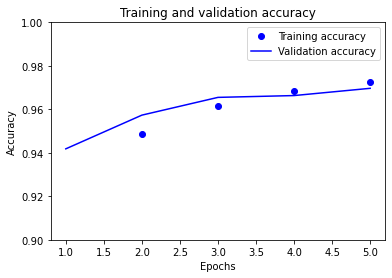

INFO:tensorflow:Assets written to: /home/earlacoa/repos/swd8_intro_ml/docs/models/model_tf_mnist/assets


INFO:tensorflow:Assets written to: /home/earlacoa/repos/swd8_intro_ml/docs/models/model_tf_mnist/assets


In [34]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# global setup
tf.keras.utils.set_random_seed(42)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS = 5

# download the data
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print(ds_train)
print(ds_info)

# preprocess the data
def normalise_image(image, label):
    return tf.cast(image, tf.float32) / 255.0, label


# create data pipelines
def training_pipeline(ds_train):
    ds_train = ds_train.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(AUTOTUNE)
    return ds_train


def test_pipeline(ds_test):
    ds_test = ds_test.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(AUTOTUNE)
    return ds_test


ds_train = training_pipeline(ds_train)
ds_val = training_pipeline(ds_val)
ds_test = test_pipeline(ds_test)


# create the model
inputs = tf.keras.Input(shape=(28, 28, 1), name="inputs")
x = tf.keras.layers.Flatten(name="flatten")(inputs)
x = tf.keras.layers.Dense(128, activation="relu", name="layer1")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu", name="layer2")(x)
outputs = tf.keras.layers.Dense(10, name="outputs")(x)

model = tf.keras.Model(inputs, outputs, name="functional")

# view the model
model.summary()

# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

# train the model
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=NUM_EPOCHS,
    verbose=False,
)

# plot the model accuracy
epochs_range = range(1, NUM_EPOCHS + 1)

plt.plot(epochs_range, history.history["accuracy"], "bo", label="Training accuracy")
plt.plot(
    epochs_range, history.history["val_accuracy"], "b", label="Validation accuracy"
)
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.9, 1.0])
plt.legend()
plt.show()

# save the model
path_models = f"{os.getcwd()}/models"
model.save(f"{path_models}/model_tf_mnist")

Now, removing non-essential code, now the experimentation phase is complete.

Here this included:

- Removing downloading data information.
- Removing unrequired print statements.
- Viewing model summary.
- Removing/replacing plots with text output.

In [42]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# global setup
tf.keras.utils.set_random_seed(42)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS = 5

# download the data
(ds_train, ds_val, ds_test) = tfds.load(
    "mnist",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

# preprocess the data
def normalise_image(image, label):
    return tf.cast(image, tf.float32) / 255.0, label


# create data pipelines
def training_pipeline(ds_train):
    ds_train = ds_train.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(AUTOTUNE)
    return ds_train


def test_pipeline(ds_test):
    ds_test = ds_test.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(AUTOTUNE)
    return ds_test


ds_train = training_pipeline(ds_train)
ds_val = training_pipeline(ds_val)
ds_test = test_pipeline(ds_test)


# create the model
inputs = tf.keras.Input(shape=(28, 28, 1), name="inputs")
x = tf.keras.layers.Flatten(name="flatten")(inputs)
x = tf.keras.layers.Dense(128, activation="relu", name="layer1")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu", name="layer2")(x)
outputs = tf.keras.layers.Dense(10, name="outputs")(x)

model = tf.keras.Model(inputs, outputs, name="functional")

# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

# train the model
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=NUM_EPOCHS,
    verbose=False,
)

# view the model accuracy
print(f"Training accuracy: {[round(num, 2) for num in history.history['accuracy']]}")
print(
    f"Validation accuracy: {[round(num, 2) for num in history.history['val_accuracy']]}"
)

# save the model
path_models = f"{os.getcwd()}/models"
model.save(f"{path_models}/model_tf_mnist")

Num GPUs Available:  0
Training accuracy: [0.88, 0.95, 0.96, 0.97, 0.97]
Validation accuracy: [0.94, 0.96, 0.97, 0.97, 0.97]
INFO:tensorflow:Assets written to: /home/earlacoa/repos/swd8_intro_ml/docs/models/model_tf_mnist/assets


INFO:tensorflow:Assets written to: /home/earlacoa/repos/swd8_intro_ml/docs/models/model_tf_mnist/assets


(refactor_into_functions)=
### Refactor Jupyter Notebook code into functions

Now, any code that is not already in functions, can be refactored into functions.

Modularising the code like this helps with diagnosing errors and creating tests.

In [46]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# global setup
tf.keras.utils.set_random_seed(42)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS = 5

# download the data
def download_data():
    (ds_train, ds_val, ds_test) = tfds.load(
        "mnist",
        split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
        shuffle_files=True,
        as_supervised=True,
        with_info=False,
    )
    return ds_train, ds_val, ds_test


# preprocess the data
def normalise_image(image, label):
    return tf.cast(image, tf.float32) / 255.0, label


# create data pipelines
def training_pipeline(ds_train):
    ds_train = ds_train.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(AUTOTUNE)
    return ds_train


def test_pipeline(ds_test):
    ds_test = ds_test.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(AUTOTUNE)
    return ds_test


# create and compile the model
def create_and_compile_model():
    inputs = tf.keras.Input(shape=(28, 28, 1), name="inputs")
    x = tf.keras.layers.Flatten(name="flatten")(inputs)
    x = tf.keras.layers.Dense(128, activation="relu", name="layer1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation="relu", name="layer2")(x)
    outputs = tf.keras.layers.Dense(10, name="outputs")(x)

    model = tf.keras.Model(inputs, outputs, name="functional")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    return model


# train the model
def train_model():
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=NUM_EPOCHS,
        verbose=False,
    )
    return history


# save the model
def save_model(model):
    path_models = f"{os.getcwd()}/models"
    model.save(f"{path_models}/model_tf_mnist")


# combine the functions in a call to main
def main():
    ds_train, ds_val, ds_test = download_data()

    ds_train = training_pipeline(ds_train)
    ds_val = training_pipeline(ds_val)
    ds_test = test_pipeline(ds_test)

    model = create_and_compile_model()
    history = train_model()
    save_model(model)


# run the functions
main()

# view the model accuracy
print(f"Training accuracy: {[round(num, 2) for num in history.history['accuracy']]}")
print(
    f"Validation accuracy: {[round(num, 2) for num in history.history['val_accuracy']]}"
)

Num GPUs Available:  0
INFO:tensorflow:Assets written to: /home/earlacoa/repos/swd8_intro_ml/docs/models/model_tf_mnist/assets


INFO:tensorflow:Assets written to: /home/earlacoa/repos/swd8_intro_ml/docs/models/model_tf_mnist/assets


Training accuracy: [0.88, 0.95, 0.96, 0.97, 0.97]
Validation accuracy: [0.94, 0.96, 0.97, 0.97, 0.97]


(create_python_script)=
### Create a Python script

First, the call to `main()` should be placed inside a conditional invocation i.e.,:

```python
if __name__ == '__main__':
    main()
```

Now, the script can be called from a terminal by running `python script.py`.

Then, the rest of the code can be convert by either:

#### Option 1 (recommended)

Convert a _single cell_ to a script using the `%%writefile` IPython magic command.

In [47]:
%%writefile jupyter-to-hpc_tf-mnist-example.py

import os

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# global setup
tf.keras.utils.set_random_seed(42)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS = 5

# download the data
def download_data():
    (ds_train, ds_val, ds_test) = tfds.load(
        "mnist",
        split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
        shuffle_files=True,
        as_supervised=True,
        with_info=False,
    )
    return ds_train, ds_val, ds_test


# preprocess the data
def normalise_image(image, label):
    return tf.cast(image, tf.float32) / 255.0, label


# create data pipelines
def training_pipeline(ds_train):
    ds_train = ds_train.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(AUTOTUNE)
    return ds_train


def test_pipeline(ds_test):
    ds_test = ds_test.map(normalise_image, num_parallel_calls=AUTOTUNE)
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(AUTOTUNE)
    return ds_test


# create and compile the model
def create_and_compile_model():
    inputs = tf.keras.Input(shape=(28, 28, 1), name="inputs")
    x = tf.keras.layers.Flatten(name="flatten")(inputs)
    x = tf.keras.layers.Dense(128, activation="relu", name="layer1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation="relu", name="layer2")(x)
    outputs = tf.keras.layers.Dense(10, name="outputs")(x)

    model = tf.keras.Model(inputs, outputs, name="functional")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    return model


# train the model
def train_model():
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=NUM_EPOCHS,
        verbose=False,
    )
    return history


# save the model
def save_model(model):
    path_models = f"{os.getcwd()}/models"
    model.save(f"{path_models}/model_tf_mnist")


# combine the functions in a call to main
def main():
    ds_train, ds_val, ds_test = download_data()

    ds_train = training_pipeline(ds_train)
    ds_val = training_pipeline(ds_val)
    ds_test = test_pipeline(ds_test)

    model = create_and_compile_model()
    history = train_model()
    save_model(model)


if __name__ == "__main__":
    # run the functions
    main()

    # view the model accuracy
    print(
        f"Training accuracy: {[round(num, 2) for num in history.history['accuracy']]}"
    )
    print(
        f"Validation accuracy: {[round(num, 2) for num in history.history['val_accuracy']]}"
    )

Writing jupyter-to-hpc_tf-mnist-example.py


#### Option 2

Convert the _entire_ notebook to a script using the `nbconvert` package:

```bash
jupyter nbconvert "my_notebook.ipynb" --to script
```

#### Option 3

Convert the _entire_ notebook to a script using the Jupyter menu.

From within the Jupyter Notebook, click `File` > `Save and Export Notebook As ...` > `Executable Script`.

This should convert the Jupyter Notebook to a `.py` file, and download it locally.

(create_submission_script)=
### Create submission script

For your HPC (e.g., ARC4), create the submission script.

For example:

```bash
#!/bin/bash
#$ -cwd
#$ -l h_rt=00:05:00
#$ -l coproc_v100=1

conda activate swd8_intro_ml 
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib  # (sometimes required)

python jupyter-to-hpc_tf-mnist-example.py
```

Ensure both of these files are on the HPC, alongside the corresponding conda environment.

(create_unit_tests)=
### (Optional) Create unit tests

It's good practise to write [tests](https://the-turing-way.netlify.app/reproducible-research/testing.html) for your code.

[pytest](https://docs.pytest.org/en/6.2.x/) are [NumPy](https://numpy.org/doc/stable/reference/testing.html) are both good, commonly-used tools for testing in Python.

There are various [levels, types, and methods](https://softwaretestingfundamentals.com/) of testing.

For example, you could [unit test](https://softwaretestingfundamentals.com/unit-testing/) individual functions, like the downloading and splitting of data:

```python
import numpy as np

def test_split_data(ds_train, ds_val, ds_test):
    num_samples_train = len(ds_train)
    num_samples_val = len(ds_val)
    num_samples_test = len(ds_test)
    
    num_samples = num_samples_train + num_samples_val + num_samples_test
    
    np.testing.assert_almost_equal(num_samples_train / num_samples, 0.8, decimal=3)
    np.testing.assert_almost_equal(num_samples_val / num_samples, 0.1, decimal=3)
    np.testing.assert_almost_equal(num_samples_test / num_samples, 0.1, decimal=3)
    

test_split_data(ds_train, ds_val, ds_test)
```

You could also perform [system testing](https://softwaretestingfundamentals.com/system-testing/). For example, checking the final validation accuracy is above a threshold:

```python
def test_final_val_accuracy_above_threshold(threshold):
    assert history.history['val_accuracy'][-1] >= threshold
    
test_final_val_accuracy_above_threshold(0.96)
```

## Exercises

```{admonition} Exercise 1

...

```

## {ref}`Solutions <distributed>`

## Key Points

```{important}

- [x] _..._

```

## Further information

### Good practices

- Ensure works on a single workers first, _before_ going distributed.
- Ensure that you need the overhead of distributing over multiple GPUs e.g., could you instead use 1 GPU and model checkpointing?
- Ensure that the problem is complex enough to use multiple GPUs efficiently.
- Batch the dataset with the global batch size e.g., for 8 devices each capable of a btach of 64 use the global batch size of 512 (= 8 * 64).  
- [Distributed training on PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/advanced/model_parallel.html)
- Performance tips from [PyTorch](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html)

### Other options

- [Horovod](https://horovod.ai/)
    - A library to make distributed deep learning fast and easy to use.
- [DeepSpeed](https://www.deepspeed.ai/)
    - A deep learning optimization library that makes distributed training easy, efficient, and effective.
- [FairScale](https://fairscale.readthedocs.io/en/latest/)
    - A PyTorch extension library for high performance and large scale training.
 
### Resources

- [PyTorch Distributed Overview](https://pytorch.org/tutorials/beginner/dist_overview.html)
- [scikit-learn parallelism](https://scikit-learn.org/stable/computing/parallelism.html)
- [Convert ML experiment to production](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-convert-ml-experiment-to-production)